In [1]:
import ee
import numpy as np

ee.Authenticate()
ee.Initialize()





To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=AKy7MDYXFlIqFeUOaNiXwWvipiTc5fGR1a2Z6lYg2Sw&tc=lje-O8iaG61WUwplCOf3mr--qTnJmIKuKKpyo_T9DWY&cc=CuzbxZSuHzhcqpGhCcyqRK_eqXzljxQZ5YiY8b5soXA

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AVHEtk57X7ImWZIZJwhmJa0RlAG73p46aaP8oafBrRXNOEtcPA5UA329ITA

Successfully saved authorization token.


In [105]:
# Define the region of interest
roi = ee.Geometry.Rectangle([77.929262, 30.194963, 78.147071, 30.376998])

# Define the time range for the image collection
start_date = '2021-01-01'
end_date = '2021-12-31'

In [106]:
landsat = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
          .filterBounds(roi) \
          .filterDate(start_date, end_date) \
          .sort('CLOUD_COVER') \
          .first()

# Load the image collection for Sentinel-2 surface reflectance
sentinel = ee.ImageCollection('COPERNICUS/S2_SR') \
           .filterBounds(roi) \
           .filterDate(start_date, end_date) \
           .sort('CLOUDY_PIXEL_PERCENTAGE') \
           .first()

In [107]:
# Calculate Normalized Difference Water Index (NDWI)
dwi = sentinel.normalizedDifference(['B3', 'B8']).rename('ndwi')

# Calculate Dissolved Oxygen
do = sentinel.expression('(-0.0167*B8A+0.0067*B9+0.0083*B11+9.577)+10', 
                         {'B8A': sentinel.select('B8A'), 'B9': sentinel.select('B9'), 'B11': sentinel.select('B11')}).rename('DO')

# Calculate Salinity
salinity = sentinel.expression('((B11-B12) / (B11 + B12))+1', 
                               {'B11': sentinel.select('B11'), 'B12': sentinel.select('B12')}).rename('Salinity')

# Calculate Temperature
temp = landsat.expression('(B11*0.00341802+149.0-273.15)+133', 
                          {'B11': landsat.select('B11')}).rename('Temperature')

# Calculate pH
ph = sentinel.expression('8.339-0.827*(B1/B8)', 
                          {'B1': sentinel.select('B1'), 'B8': sentinel.select('B8')}).rename('pH')

# Calculate Turbidity
turbidity = sentinel.expression('((B4 - B3) / (B4 + B3))+0.1', 
                                 {'B3': sentinel.select('B3'),  'B4': sentinel.select('B4')}).rename('Turbidity')

# Calculate Dissolved Organic Matter
dom = sentinel.expression('((B7 * B5) / B3)/9', 
                           {'B7': sentinel.select('B7'), 'B5': sentinel.select('B5'), 'B3': sentinel.select('B3')}).rename('Dissolved Organic Matter')

# Calculate Suspended Matter
sm = sentinel.expression('((B3 * B5) / B8)*4', 
                          {'B3': sentinel.select('B3'), 'B5': sentinel.select('B5'), 'B8': sentinel.select('B8')}).rename('Suspended Matter')

# Calculate Chlorophyll
chlorophyll = sentinel.expression('((B5-B4)/(B5+B4))-0.5', 
                                   {'B4': sentinel.select('B4'), 'B5': sentinel.select('B5')}).rename('Chlorophyll')

In [108]:
latlon = ee.Image.pixelLonLat() \
         .addBands(ph) \
         .addBands(do) \
         .addBands(salinity) \
         .addBands(temp) \
         .addBands(turbidity) \
         .addBands(dom) \
         .addBands(sm) \
         .addBands(chlorophyll) \
         .addBands(dwi) 
          
        

In [109]:
data = latlon.reduceRegion(reducer=ee.Reducer.first(), geometry=roi, scale=30).toArray()

In [110]:
latlon = ee.Image.pixelLonLat().addBands(ph).addBands(do).addBands(salinity).addBands(temp).addBands(turbidity).addBands(dom).addBands(sm).addBands(chlorophyll)


latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=roi,
  scale=100);

data_ph = np.array((ee.Array(latlon.get("pH")).getInfo()))
data_salinity = np.array((ee.Array(latlon.get("Salinity")).getInfo()))
data_do = np.array((ee.Array(latlon.get("DO")).getInfo()))
data_temp = np.array((ee.Array(latlon.get("Temperature")).getInfo()))
data_turbidity = np.array((ee.Array(latlon.get("Turbidity")).getInfo()))
data_dom = np.array((ee.Array(latlon.get("Dissolved Organic Matter")).getInfo()))
data_sm = np.array((ee.Array(latlon.get("Suspended Matter")).getInfo()))
data_chlorophyll = np.array((ee.Array(latlon.get("Chlorophyll")).getInfo()))

In [111]:
import pandas as pd
df = pd.concat([pd.DataFrame(data_ph, columns=['pH']),
                pd.DataFrame(data_salinity, columns=['Salinity']),
                pd.DataFrame(data_do, columns=['Dissolved Oxygen']),
                pd.DataFrame(data_temp, columns=['Temperature']),
                pd.DataFrame(data_turbidity, columns=['Turbidity']),
                pd.DataFrame(data_dom, columns=['Dissolved Organic Matter']),
                pd.DataFrame(data_sm, columns=['Suspended Matter']),
                pd.DataFrame(data_chlorophyll, columns=['Chlorophyll'])], 
                axis=1)

# Save the dataset as a CSV file
df.to_csv('water_quality_data1.csv', index=False)

In [112]:
df.head()

,pH,Salinity,Dissolved Oxygen,Temperature,Turbidity,Dissolved Organic Matter,Suspended Matter,Chlorophyll
0,8.256581,1.307804,10.3111,18.820364,0.054151,357.311737,586.737976,-0.200000
1,8.265224,1.315706,8.1113,18.813528,0.017614,361.328674,466.336700,-0.172216
2,8.271290,1.348837,7.9296,18.799856,-0.027389,355.900818,385.328918,-0.145465
3,8.281897,1.376302,7.3713,18.786184,-0.093676,348.139069,283.480438,-0.091304
4,8.280197,1.362225,8.8081,18.782766,-0.084158,336.939423,294.325775,-0.093660


In [113]:
df


,pH,Salinity,Dissolved Oxygen,Temperature,Turbidity,Dissolved Organic Matter,Suspended Matter,Chlorophyll
0,8.256581,1.307804,10.3111,18.820364,0.054151,357.311737,586.737976,-0.200000
1,8.265224,1.315706,8.1113,18.813528,0.017614,361.328674,466.336700,-0.172216
2,8.271290,1.348837,7.9296,18.799856,-0.027389,355.900818,385.328918,-0.145465
3,8.281897,1.376302,7.3713,18.786184,-0.093676,348.139069,283.480438,-0.091304
4,8.280197,1.362225,8.8081,18.782766,-0.084158,336.939423,294.325775,-0.093660
...,...,...,...,...,...,...,...,...
49324,8.302407,1.349296,9.2537,18.748586,-0.038539,336.208466,204.500000,-0.089655
49325,8.278749,1.258456,12.0194,18.813528,0.096914,358.222229,434.970306,-0.185048
49326,8.280500,1.279165,10.5942,18.820364,0.064856,374.079224,399.022888,-0.165932
49327,8.292296,1.319277,7.3916,18.810110,-0.029371,447.306488,382.617065,-0.057047


In [114]:

df = pd.read_csv('water_quality_data1.csv')

# Drop all rows containing null values
df = df.dropna()

# Save the cleaned data to a new CSV file
df.to_csv('cleaned_water_quality_data1.csv', index=False)

In [115]:
## Fill missing values with median
for feature in df.columns:
    df[feature].fillna(df[feature].median() , inplace = True)

In [116]:
df

,pH,Salinity,Dissolved Oxygen,Temperature,Turbidity,Dissolved Organic Matter,Suspended Matter,Chlorophyll
0,8.256581,1.307804,10.3111,18.820364,0.054151,357.311737,586.737976,-0.200000
1,8.265224,1.315706,8.1113,18.813528,0.017614,361.328674,466.336700,-0.172216
2,8.271290,1.348837,7.9296,18.799856,-0.027389,355.900818,385.328918,-0.145465
3,8.281897,1.376302,7.3713,18.786184,-0.093676,348.139069,283.480438,-0.091304
4,8.280197,1.362225,8.8081,18.782766,-0.084158,336.939423,294.325775,-0.093660
...,...,...,...,...,...,...,...,...
49324,8.302407,1.349296,9.2537,18.748586,-0.038539,336.208466,204.500000,-0.089655
49325,8.278749,1.258456,12.0194,18.813528,0.096914,358.222229,434.970306,-0.185048
49326,8.280500,1.279165,10.5942,18.820364,0.064856,374.079224,399.022888,-0.165932
49327,8.292296,1.319277,7.3916,18.810110,-0.029371,447.306488,382.617065,-0.057047


In [117]:
## find dublicate rows in dataset
duplicate = df[df.duplicated()]
duplicate

,pH,Salinity,Dissolved Oxygen,Temperature,Turbidity,Dissolved Organic Matter,Suspended Matter,Chlorophyll


In [118]:
for i in df.columns:
    print(f" {i}  :  {len(df[i].unique())}")

 pH  :  44215
 Salinity  :  42333
 Dissolved Oxygen  :  46976
 Temperature  :  94
 Turbidity  :  31779
 Dissolved Organic Matter  :  48949
 Suspended Matter  :  49200
 Chlorophyll  :  36303


In [119]:
df = pd.read_csv('cleaned_water_quality_data1.csv')

df.isnull().sum()

pH                          0
Salinity                    0
Dissolved Oxygen            0
Temperature                 0
Turbidity                   0
Dissolved Organic Matter    0
Suspended Matter            0
Chlorophyll                 0
dtype: int64

In [120]:
# Calculate density
df['Density'] = (999.842594 + (0.06793952 * df['Temperature']) - (0.00909529 * df['Temperature'] ** 2) + (1.001685e-4 * df['Temperature'] ** 3) - (1.120083e-6 * df['Temperature'] ** 4) + (6.536332e-9 * df['Temperature'] ** 5)) + ((0.824493 - (0.0040899 * df['Temperature']) + (7.6438e-05 * df['Temperature'] ** 2) - (8.2467e-7 * df['Temperature'] ** 3) + (5.3875e-9 * df['Temperature'] ** 4)) * df['Salinity']) + (-0.00572466 + (1.0227e-4 * df['Temperature']) - (1.6546e-6 * df['Temperature'] ** 2)) * df['Salinity'] ** 1.5 + (4.8314e-4 - (6.7746e-6 * df['Temperature']) + (8.7339e-8 * df['Temperature'] ** 2)) * df['Salinity'] ** 2

# Save the dataset as a CSV file
df.to_csv('new_water_quality_data_with_density.csv', index=False)

In [121]:
import matplotlib.pyplot as plt

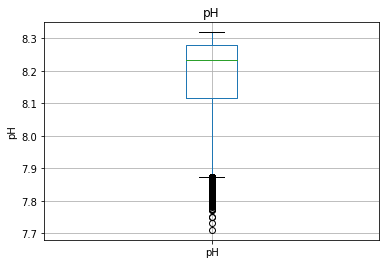

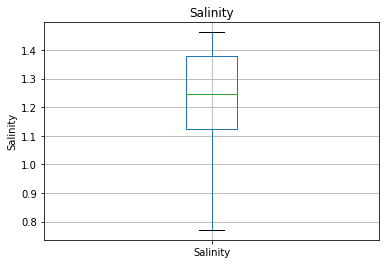

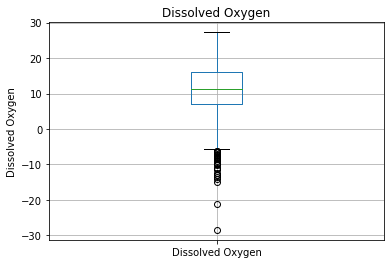

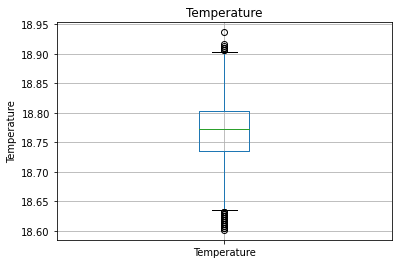

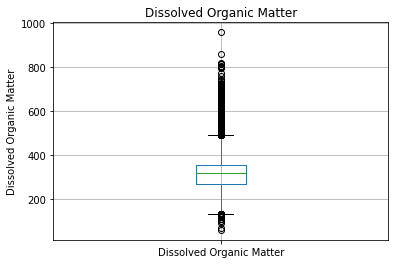

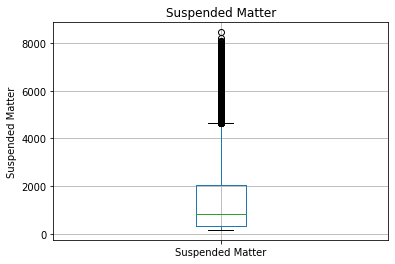

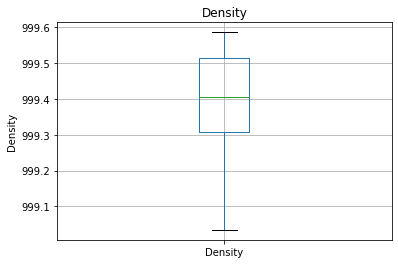

In [122]:
for feature in df.columns:
    if 0 in df[feature].unique():
        pass
    else:
        df.boxplot(column=feature)
        plt.ylabel(feature)
        plt.title(feature)
        plt.show() 

In [123]:
# removing outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

pH                             0.162427
Salinity                       0.252561
Dissolved Oxygen               8.878500
Temperature                    0.068360
Turbidity                      0.251784
Dissolved Organic Matter      89.677734
Suspended Matter            1723.491669
Chlorophyll                    0.290788
Density                        0.206501
dtype: float64


In [124]:
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape

(47936, 9)

In [125]:
import seaborn as sns

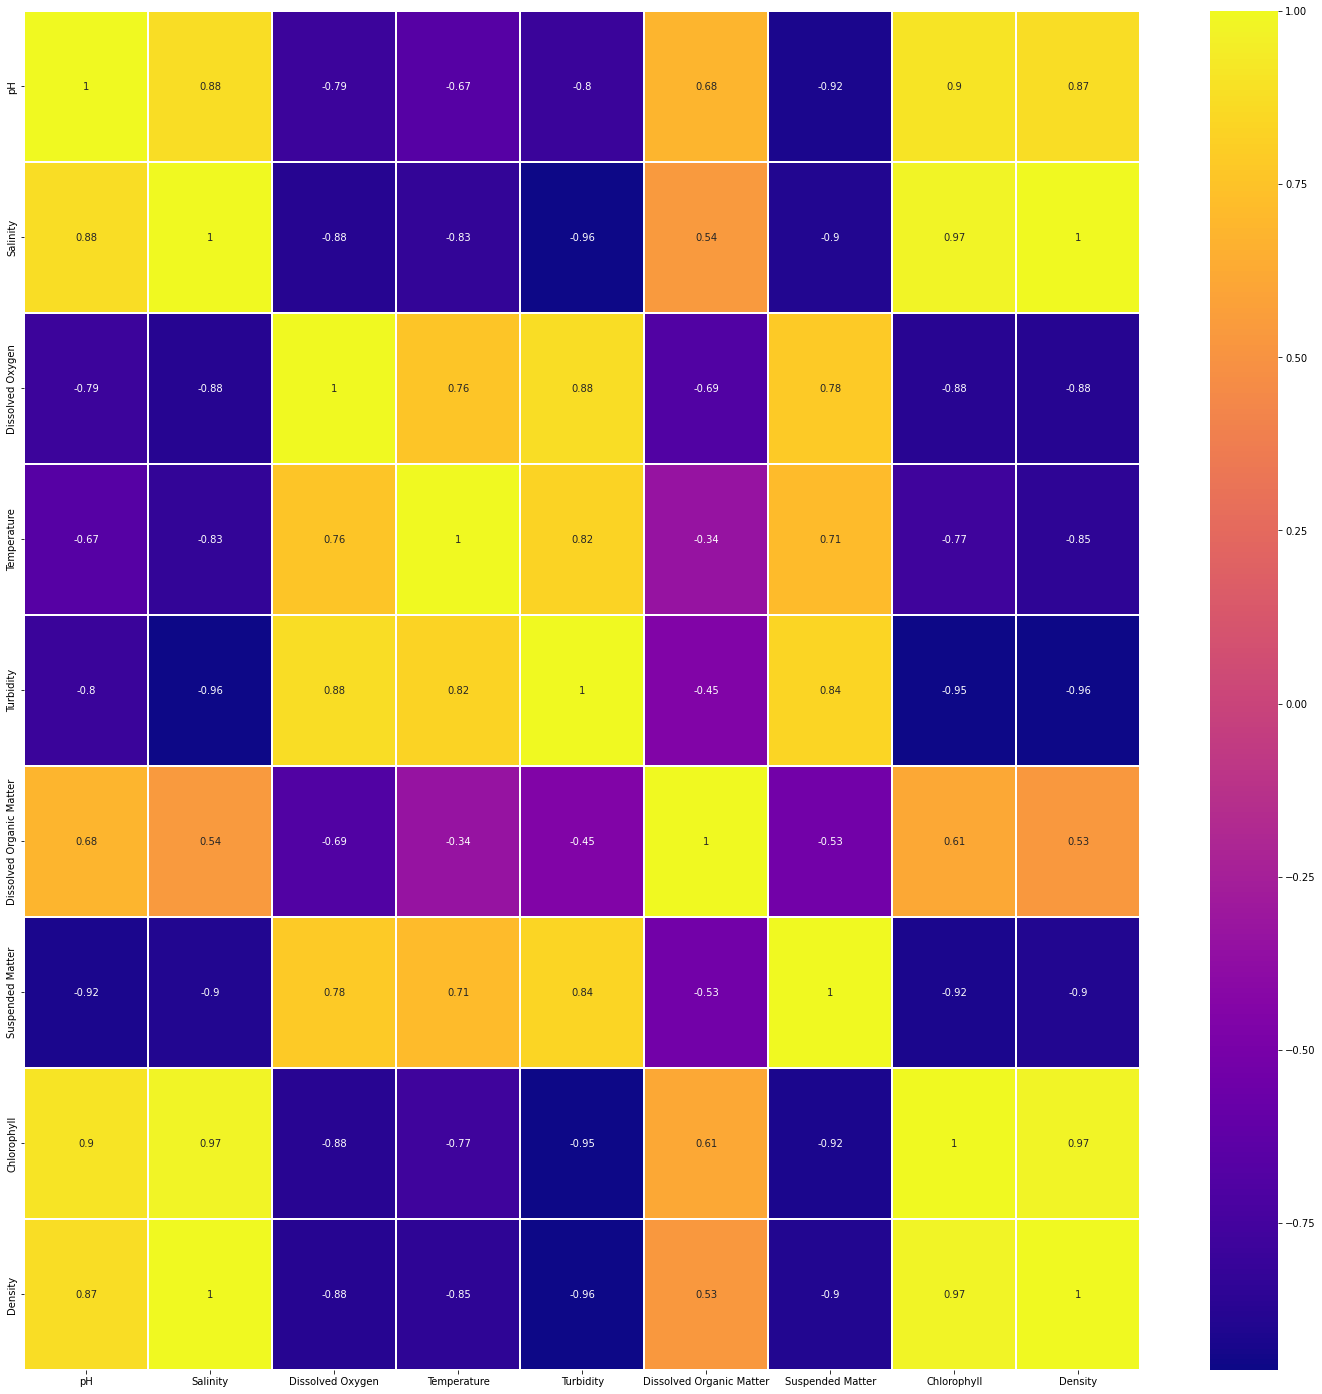

In [126]:
plt.figure(figsize=(25,25))
ax = sns.heatmap(df.corr(), cmap = "plasma", annot=True, linewidth=2)

In [127]:
df.to_csv('clean_water_quality_datafinal.csv', index=False)

In [128]:
def label_water_quality(row):
    if 6.5 <= row['pH'] <= 8.5 and row['Salinity'] > 1 and -0.2 <= row['Turbidity'] <= 0 and 15 <= row['Temperature'] <= 35 and -0.1 <= row['Chlorophyll'] <= 0.1 and 300 <= row['Suspended Matter'] <= 600 and row['Dissolved Organic Matter'] < 500 and row['Dissolved Oxygen'] > 6.5:
        return 'Good'
    elif (4 <= row['pH'] <= 6.5 or 8.5 <= row['pH'] <= 11) and 0 <= row['Salinity'] <= 1 and 0 <= row['Turbidity'] <= 0.2 and (row['Temperature'] > 35 or row['Temperature'] < 15) and 0.1 <= row['Chlorophyll'] <= 0.5 and 600 <= row['Suspended Matter'] <= 900 and 500 <= row['Dissolved Organic Matter'] <= 2000 and 4 <= row['Dissolved Oxygen'] <= 6.5:
        return 'Needs Treatment'
    elif (1 <= row['pH'] <= 4 or 11 <= row['pH'] <= 14) or row['Salinity'] < 0 or row['Turbidity'] > 0.2 or row['Temperature'] > 40 or row['Temperature'] < 5 or row['Chlorophyll'] > 0.5 or 900 <= row['Suspended Matter'] <= 1200 or row['Dissolved Organic Matter'] > 2000 or row['Dissolved Oxygen'] < 4:
        return 'Poor'
    else:
        return 'Unknown'
    
# Apply the function to create a new column "Water Quality"
df['Water Quality'] = df.apply(lambda row: label_water_quality(row), axis=1)

# Save the labeled dataset as a CSV file
df.to_csv('labeled_water_quality_data.csv', index=False)

In [129]:
df["Water Quality"].value_counts()

Unknown    39351
Poor        5139
Good        3446
Name: Water Quality, dtype: int64

In [130]:
### splitting data into x and y
X = df.iloc[: , : -1]
y = df.iloc[ : , -1]

In [131]:
# split dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 5)

In [132]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_final = sc.fit_transform(X_train)
X_test_final = sc.transform(X_test)

In [133]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [134]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators = 30, criterion = 'entropy', class_weight = "balanced_subsample",random_state = 51)
rf_classifier.fit(X_train_final, y_train)
y_pred = rf_classifier.predict(X_test_final)
accuracy_score(y_test, y_pred)

0.9991655656769348

In [135]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Good       1.00      1.00      1.00      1005
        Poor       1.00      1.00      1.00      1581
     Unknown       1.00      1.00      1.00     11795

    accuracy                           1.00     14381
   macro avg       1.00      1.00      1.00     14381
weighted avg       1.00      1.00      1.00     14381



In [137]:
from sklearn.svm import SVC
svc_classifier = SVC(class_weight = "balanced" )
svc_classifier.fit(X_train_final, y_train)
y_pred_scv = svc_classifier.predict(X_test_final)
accuracy_score(y_test, y_pred_scv)

0.8103052638898547

In [138]:
print(classification_report(y_test, y_pred_scv))

              precision    recall  f1-score   support

        Good       0.44      0.99      0.61      1005
        Poor       0.52      0.99      0.68      1581
     Unknown       1.00      0.77      0.87     11795

    accuracy                           0.81     14381
   macro avg       0.65      0.92      0.72     14381
weighted avg       0.91      0.81      0.83     14381

